# Article Recommender for IBM Watson Users

Note: This workspace is based on a project on the Udacity Data Science Nanodegree 



In [239]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df_user_item = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df_user_item['Unnamed: 0'] #Remove redundant column
del df_content['Unnamed: 0'] #Remove Redundant column

#### User-item Interaction dataframe:

This table details observed user accesses to articles on the IBM Watson server.   
Take the email column to be a user number (it will be transformed later).  
Accoring to the table, users access multiple articles and sometimes even the same article more than 1 time.  
The distribution of number of articles accesses is illustrated later.   

The distribution of a particualar user (email) is generally located in a portion of the dataset. For example, user 4 appears 45 times between rows 3 and 24864. The dataset may be a time-related log of accesses; in witch case, it would be natural for accesses by a particualar user to happen in bursts. I observed this by digging into 4 or 5 big-hitter user patterns rather than a broad investigation across all users but enough to know that for splitting the dataset into a training and testing subset some care would need to be taken (see matrix factorisation section below). 


In [2]:
print(df_user_item.shape)
df_user_item.head(10)

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


#### Content dataframe

Details of articles indexed by the article ID.

Subtracting duplicates, there are around 1050 unique article IDs here.  
The indices range from 0 to 1050.  
Note that only a subset of these feature in the user-item dataframe.  
Unfortunetly, there are are article IDs in the user-item dataframe that are not contained here in the content df.  

In [22]:
print(df_content.shape)
df_content.head()

(1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## Exploratory Data Analysis

First look at the user-item interaction dataset:

In [4]:

print("Length of user-item interaction dataset:", df_user_item.shape[0] )
df_user_item['article_id'].is_unique
#investigate duplicates
print("Number of duplicates is:", df_user_item['article_id'].duplicated().sum())
print("So it seems that this is a table of accesses to articles; hence the repetition of the article IDs")

#It truns out that the articles community file only contains details of article IDs 0 to 1050
print ("\nNumber of Interactions related to an article contained in the article community file:", (df_user_item['article_id'] <= 1050).sum())

Length of user-item interaction dataset: 45993
Number of duplicates is: 45279
So it seems that this is a table of accesses to articles; hence the repetition of the article IDs

Number of Interactions related to an article contained in the article community file: 21454


Let's get a feel of how often and the distribution of how many articles a user interacts with in the dataset:

In [5]:
unique_for_each_user = df_user_item[['email','article_id']].groupby(['email']).nunique()

In [18]:
striped_unique_for_each_user = unique_for_each_user['article_id'].values

Text(0.5, 1.0, 'Focus on 0 to 20 region of above distribution')

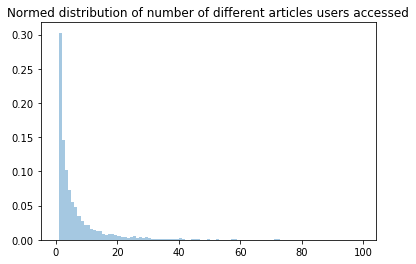

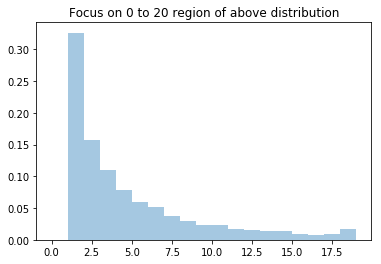

In [19]:
ax = sns.distplot(striped_unique_for_each_user, bins=np.arange(0,100), kde=False, norm_hist=True )
ax.set_title("Normed distribution of number of different articles users accessed")
plt.figure()
ax2 = sns.distplot(striped_unique_for_each_user, bins=np.arange(0,20), kde=False, norm_hist=True )
ax2.set_title("Focus on 0 to 20 region of above distribution")


In [180]:
median_value = np.median(striped_unique_for_each_user)
print("50%% of individuals interact with %i number of articles or fewer" % int(median_value))

50% of individuals interact with 3 number of articles or fewer


In [195]:
max_value = np.max(df_user_item['email'].value_counts())
print("The maximum number of user-article interactions by any 1 user is:", max_value)

The maximum number of user-article interactions by any 1 user is: 364


Explore and remove duplicate articles from the df_content dataframe:

In [96]:
duplicate_subset = df_content[df_content['article_id'].duplicated()]

In [97]:
print(duplicate_subset)

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [123]:
df_content = df_content.drop(list(duplicate_subset.index),axis=0)
print("New length of df_content:", df_content.shape[0])

New length of df_content: 1051


In [197]:
n_uniq_interaction = df_user_item['article_id'].nunique(dropna=True)
print("Number of unique articles that have an interaction with a user:", n_uniq_interaction )

Number of unique articles that have an interaction with a user: 714


In [ ]:
df_user_item['article_id'].unique()

In [199]:
#The total number of unique articles on the IBM platform

unique_articles = df_content['article_id'].unique()

print("Number of unique articles in the dataset (whether they have any interactions or not):", len(unique_articles) )

Number of unique articles in the dataset (whether they have any interactions or not): 1051


In [150]:
#Users are identified by email
unique_users = df_user_item['email'].nunique(dropna=True)
print("Number of unique users in the dataset. (excluding null values):", unique_users )

Number of unique users in the dataset. (excluding null values): 5148


In [152]:
print("Number of user-article interactions in the dataset:", df_user_item.shape[0] )

Number of user-article interactions in the dataset: 45993


In [171]:
most_pop_article =df_user_item['article_id'].value_counts().index[0]
max_counts = df_user_item['article_id'].value_counts().values[0]

print("Most viewed article_id:", int(most_pop_article) )
print("How often it was viewed:", max_counts)

Most viewed article_id: 1429
How often it was viewed: 937


## Preprossing of the user-item interaction dataset

Convert the email githash line to a user id line. 

Note: Udacity suggested using that the all the NaN values in the email column should be assumed to be from the the same user and therefore all get the same user id number. The code below achieves this effect.

In [3]:
coded_dict = dict()
user_increment = 1
email_encoded = []
    
for val in df_user_item['email']:
    #If this is the first time we encounter the email githash
    if val not in coded_dict:
        coded_dict[val] = user_increment
        user_increment+=1
    #Add the user id    
    email_encoded.append(coded_dict[val])

del df_user_item['email']
df_user_item['user_id'] = email_encoded

In [4]:
#Udacity specifies that the article_id needs to be of type string. I'm not sure why that is...
#but I make the change here so that any tests they do will pass.

df_user_item['article_id'] = df_user_item['article_id'].astype(str)

In [5]:
df_user_item.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


## Rank-Based Recommendations

First, Let's implement a very simple rank-based recommender

We don't really have much to go on here for ranking the articles except for the number of times the article was accessed. Our ranks will, therefore, be based on that.


In [8]:
def get_top_articles(n, df=df_user_item):
    """
    Returns a list of the top articles in a user-item interaction dataframe

    Args:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df of user-item interactions as defined at the top of the notebook 
    
    Returns:
        top_articles - (list) A list of the top 'n' article titles 
    """
    
    top_articles = df['title'].value_counts(dropna=True).index[:n]
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df_user_item):
    """
    Returns a list of indexes of the top articles in a user-item interaction dataframe

    Args:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
    
    Returns:
        top_articles - (list) A list of the top 'n' article id's
    """
     
    top_articles = df['title'].value_counts(dropna=True).values[:n]    
        
    return top_articles # Return the top article ids

The **top ten** articles according to our rank-based recommender are:

In [10]:
print(get_top_articles(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')


..And they correspond to the following article ids:

In [11]:
print(get_top_article_ids(10))

[937 927 671 643 627 614 572 565 512 483]


## User-User Based Collaborative Filtering

The first step is to create a matrix with users as the rows and articles as the columns. 1 row for every unique user. 1 column for every article.



In [12]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    """
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise

    Args:
        df - pandas dataframe with article_id, title, user_id columns
    
    Returns:
        user_item - user item matrix 
    """
    df_local = df[['user_id', 'article_id']]
    df_local = df_local.dropna(axis=0, subset=['user_id'])
    #Create a "value" column to be used as values in the pivot_table operation
    df_local['value'] = 1
    user_item = df_local.pivot_table(index='user_id', columns='article_id', values='value', fill_value=0)
    
    return user_item # return the user_item matrix 


Create the User-Item Matrix:

In [13]:
user_item_sparse_matrix = create_user_item_matrix(df_user_item)

In [149]:
def find_similar_users(user_id, user_item=user_item_sparse_matrix):
    """
    Computes the similarity of every pair of users based on the dot product

    Args:
        user_id -            (int) a user_id
        user_item -          (pandas dataframe) matrix of users by articles: 
                                 1's when a user has interacted with an article, 0 otherwise
    
    Returns:
        most_similar_users - (list) an ordered list where the closest users (largest dot product users)
                                 are listed first
    """
    
    # compute similarity of each user to the provided user
    user_item_t = user_item.transpose()
    dot_prod = user_item.loc[user_id,:].dot(user_item_t)
        
    # sort by similarity
    most_similar_users = list(dot_prod.sort_values(ascending=False).index)
    #ignore similarity with its self (note that this may not necessarily be in the first position..
    #if there is a tie for the most simillar)
    most_similar_users.remove(user_id)
    
       
    return most_similar_users # return a list of the users in order from most to least similar

In [157]:
def get_article_names(article_ids, df=user_item_sparse_matrix):
    """
    Returns list of article names based on ids

    Args:
        article_ids -   (list) a list of article ids
        df -            (pandas dataframe) user-item interaction dataframe as defined
                            at the top of the notebook
    
    Returns:
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the title column)
    """
        
    article_names = []
    for article_id in article_ids:
        article_names.append((df[df['article_id'] == article_id]['title']).unique()[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item_sparse_matrix):
    """
    Provides a list of the article_ids and article titles that have been seen by a user

    Args:
        user_id -       (int) a user id
        user_item -     (pandas dataframe) matrix of users by articles: 
                            1's when a user has interacted with an article, 0 otherwise
    
    Returns:
        article_ids -   (list) a list of the article ids seen by the user
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the doc_full_name column in df_content)
    """
    
    user_row = user_item.loc[user_id,:]
    
    article_ids = list(user_row[user_row == 1].index)
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    """
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Continues until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily

    Args:
        user_id -          (int) a user id
        m -                (int) the number of recommendations you want for the user
    
    Returns:
        recommendations -  (list) a list of recommendations for the user
    """
    
    sim_users = find_similar_users(user_id)

    rec_ids = []
    rec_names = []

    for sim_user in sim_users:
        art_ids, _ = get_user_articles(sim_user)
        rec_ids.extend(art_ids)
        if len(rec_ids) > m:
            break
    
    #If there are more than m in the rec_names list we onyl want to return m
    if len(rec_ids) < m:
        recommendations = rec_ids
    else:
        recommendations = rec_ids[:m]
       
    return recommendations # return your recommendations for this user_id    

#### Some usage of above functions:

Get the top 15 recommended articles for user 20

In [175]:
get_article_names(user_user_recs(115, 15))

['finding optimal locations of new store using decision optimization',
 'simple graphing with ipython and\xa0pandas',
 'house building with worker skills',
 'learn basics about notebooks and apache spark',
 'maximize oil company profits',
 'model a golomb ruler',
 'this week in data science (february 7, 2017)',
 'the nurse assignment problem',
 'the unit commitment problem',
 'use decision optimization to schedule league games',
 'hyperparameter optimization: sven hafeneger',
 'access db2 warehouse on cloud and db2 with python',
 'access mysql with python',
 'access mysql with r',
 'access postgresql with python']

### Making an improvment on the user-user based Collaborative filtering 

Now we are going to improve the consistency of the **user_user_recs** function from above by: 

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function above.

In [370]:
def get_top_sorted_users(user_id, df=df, user_item=user_item_sparse_matrix):
    """
    sort the neighbors_df by the similarity and then by number of interactions where 
        highest of each is higher in the dataframe
    
    Args:
        user_id -   (int)
        df -        (pandas dataframe) df as defined at the top of the notebook 
        user_item - (pandas dataframe) matrix of users by articles: 
                        1's when a user has interacted with an article, 0 otherwise
    
    Returns:
        neighbors_df -     (pandas dataframe) a dataframe with
                                neighbor_id -      is a neighbor user_id
                                similarity -       measure of the similarity of each user to the provided user_id
                                num_interactions - the number of articles viewed by the user 
    """   
    
    

    user_item_t = user_item.transpose()
    dot_prod = user_item.loc[user_id,:].dot(user_item_t)
    
    num_interactions = []
    for user in dot_prod.index:
        interactions = (df['user_id'] == user).sum()
        num_interactions.append(interactions)
    #Convert to a numpy array to allow for simple inclusion in the data_prod_df dataframe
    num_interactions_np = np.array(num_interactions)
    
    #Combine dot_prod and num_interactions together in a dataframe for sorting together
    dot_prod_df = pd.DataFrame(dot_prod)
    dot_prod_df = dot_prod_df.rename(columns={user_id: "similarity"})
    dot_prod_df['num_interactions']  = num_interactions_np[dot_prod.index -1]
    
    neighbors_df = dot_prod_df.sort_values(['similarity', 'num_interactions'],ascending=False)
    
    neighbors_df = neighbors_df.reset_index()
    neighbors_df = neighbors_df.rename(columns={"user_id": "neighbor_id"})
    
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
        
    return neighbors_df # Return the dataframe specified in the doc_string


def sort_articles(articles, df=df_user_item):
    """
    Sorts a list of article ids in order of the number of accesses the articles have.

    Args:
        articles -  (list) a list of article ids
        df -        (pandas dataframe) user-item interaction dataframe as defined
                            at the top of the notebook
    
    Returns:
        sorted_articles - (list) sorted list of articles
    """
    
    #First, get the number of accesses for each article in list
    num_accessed = []
    for article in articles:
        accessed = (df_user_item['article_id'] == article).sum()
        num_accessed.append(accessed)
    num_accessed_np = np.array(num_accessed)

    #Next, sort the input list according to the number of accesses
    #We do this rather clumilsy by combining the article id and the num of accesses for the articles..
    #into one dataframe and sorting on accesses. The article_id column is then sorted in the desired order
    art_ids_df = pd.DataFrame(articles)
    art_ids_df['accesses'] = num_accessed_np
    art_ids_df = art_ids_df.rename(columns={0: "article_id"})
    art_ids_df = art_ids_df.sort_values(['accesses'],ascending=False)
    sorted_articles = art_ids_df['article_id'].values
    
    return sorted_articles

def user_user_recs_part2(user_id, m=10):
    """
    Loops through the users based on closeness to the input user_id
    For each user : finds articles the user hasn't seen before and provides them
    as recommendations. Continues until m recommendations are found
    
    Notes:
    * Favours users with more article interactions before choosing 
    those with fewer article interactions.

    * Favours articles with the most total interactions before choosing 
    those with fewer total interactions. 

    Args:
        user_id - (int) a user id
        m -      (int) the number of recommendations you want for the user
    
    Returns:
        recommended_ids -    (list) a list of recommendations for the user by article id
        recommended_names -  (list) a list of recommendations for the user by article title
    """

    similar_users = get_top_sorted_users(user_id)

    recommended_ids = []

    #Go through the most similar users and take recommendations from each in turn
    #Stop the process when recommendations obtained > m
    for similar_index,similar_row in similar_users.iterrows():
        art_ids, _ = get_user_articles(similar_row['neighbor_id'])
        
        #sort the articles so that the most relevent are to be included in case the
        #m cutoff point is reached.
        sorted_article_ids = sort_articles(art_ids)
        
        recommended_ids.extend(sorted_article_ids)
        if len(recommended_ids) > m:
            break

    #If there are more than m in the rec_names list we only want to return m
    if len(recommended_ids) < m:
        recommended_ids = recommended_ids
    else:
        recommended_ids = recommended_ids[:m]
       
    recommended_names = get_article_names(recommended_ids)
    
    return recommended_ids, recommended_names

#### Some usage of above functions:

Get the top 15 recommended articles for user 20

In [374]:
_, rec_names = user_user_recs_part2(20, 15)

In [375]:
rec_names

['insights from new york car accident reports',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model',
 'model bike sharing data with spss',
 'analyze accident reports on amazon emr spark',
 'movie recommender system with spark machine learning',
 'putting a human face on machine learning',
 'ml optimization using cognitive assistant',
 'learn basics about notebooks and apache spark',
 'apache spark lab, part 3: machine learning',
 'deploy your python model as a restful api',
 'analyze open data sets with spark & pixiedust']

#### Observations on the above collaborative filtering algo

*I observed that with the above algorithm it is typcial that all a users recommendations may come from 1 single other user (albeit a similar user). This is not ideal in terms of diversification of suggestions. To rectify this the algo could take pick off recommendations in a cycle from k nearest neighbours. There is a discussion [here](https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff) on how to measure diversification. Some features of the suggestions are needed to measure diversification. Perhaps through clustering of NLP features of the body of text we could do something here.* 



## Matrix Factorization using SVD

In [14]:
user_item_sparse_matrix.shape

(5149, 714)

#### Testing SVD with missing values present:

In [20]:
temp_sparse_matrix = user_item_sparse_matrix
temp_sparse_matrix.iloc[1,1] = np.NaN
print("Total Missing values in temp_sparse_matrix:", temp_sparse_matrix.isnull().sum().sum() )

#Try SVD
try:
    u, s, vt = np.linalg.svd(temp_sparse_matrix)
except Exception as error:
    print("SVD failed with following error:", str(error))
else:
    print("SVD worked")


Total Missing values in temp_sparse_matrix: 1
SVD failed with following error: SVD did not converge


*As can be seen below, the user_item matrix is very much sparse. However it does not contain nans. We have a binary classification of either 0 (user did not access article) or 1 (user did access article).*

*According to [this](http://nicolas-hug.com/blog/matrix_facto_3) explaination of matrix factorization, SVD can be carried out on a sparse matrix when we mean sparse to mean a lot of zeros and few non-zero values. However the SVD is not defined when there are missing values that we are trying to predict.*

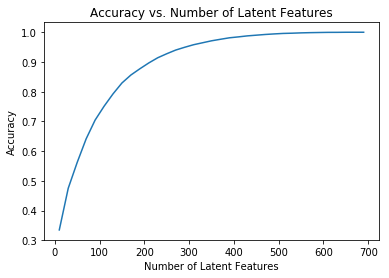

In [ ]:
# Change the dimensions of u, s, and vt as necessary to use four latent features
# update the shape of u and store in u_new
u_new = u[:, :len(s)]

# update the shape of s and store in s_new
s_new = np.zeros((len(s), len(s)))
s_new[:len(s), :len(s)] = np.diag(s) 

# Because we are using 4 latent features and there are only 4 movies, 
# vt and vt_new are the same
vt_new = vt

Split the user-iteraction dataset into an offline training and testing subset:

In [83]:
def create_test_and_train_user_item(df_user_item, ratio):
    """
    Creates a test and train set.

    Args:
        df_user_item -  user-item interaction dataframe to be split
        df_test -   test dataframe
    
    Returns:
        user_item_train - a user-item matrix of the training dataframe 
                          (unique users for each row and unique articles for each column)
        user_item_test -  a user-item matrix of the testing dataframe 
                          (unique users for each row and unique articles for each column)
        train_idx -       all of the train user ids
        train_arts -      all of the train article ids              
        
    """
    #First, we shuffle the user-item df. As mentioned, at the top of this workbook, the.. 
    #user-item dataset seems to have a temporal nature and the accesses of a particular..
    #user are usually clustered in a region of the dataset. Therefore if we split down..
    #the original dataset there will be poor overlap of users. Not what we want for our..
    #testset.  
    user_item_shuffled = df_user_item.sample(frac=1)
    
    split_point = int(ratio*df_user_item.shape[0])
    df_train = user_item_shuffled[:split_point]
    df_test = user_item_shuffled[split_point:]
    
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = np.array(user_item_train.index)
    train_arts = np.array(user_item_train.columns)
        
    return user_item_train, user_item_test, train_idx, train_arts

In [84]:
user_item_train, user_item_test, train_idx, train_arts = create_test_and_train_user_item(df_user_item, 0.8)

In [26]:
user_item_train.loc[3998, [ '1014.0']]

article_id
1014.0    0
Name: 3998, dtype: int64

Fit the SVD on the training subset: 

In [85]:
u, s, vt = np.linalg.svd(user_item_train)
print(u.shape, s.shape, vt.shape)

(4850, 4850) (709,) (709, 709)


#### Predict a single value in the test dataset:

In [87]:
#Now use the fitted model to predict a value in the test subset

def predict_suitability(user_id, article_id,  u, s, vt, k=200):

    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    #using the original user id and article id used in the dataframe
    #(The index and column names got stripped in the SVD call)
    user_row = np.where(train_idx == user_id)[0][0]
    article_col = np.where(train_arts == article_id)[0][0]

    #should have np.round here
    predict = (np.dot(np.dot(u_new[user_row, :], s_new), vt_new[:, article_col]))

    return predict

In [88]:
predict_suitability(3998, '1014.0', u, s, vt, k=200)

0.9407779380433723

#### Obtain score based on test set to rate SVD

In [89]:
u, s, vt = np.linalg.svd(user_item_train)
print(u.shape, s.shape, vt.shape)

(4850, 4850) (709,) (709, 709)


*Next we create a subset of the test dataset that contains only users that are also in the training set. Users outside of his subset can be considered to be a different problem: dealing with new users (a.k.a. the cold-start problem)*

In [234]:
test_subset = user_item_test[user_item_test.index.isin(train_idx)]

#trim off columns in the testset that do not exist in the training set
intersection_cols = test_subset.columns & trimmed_estimates_temp.columns
test_subset = test_subset[intersection_cols]

In [250]:
def latent_feature_sweep(test_data, s, u, vt, latent_feature_num_list, score_func):
    """
    Evaluate performance of SVD algo 

    Args:
        test_data -                test subset of data to be compared against
        s, u, vt -                 SVD components
        latent_feature_num_list -  list of number of latent features to be analyised
        score_func -               score function to be used to evaluate performace. 
                                   One of [f1_score, precision_score, recall_score]
    
    Returns:
        score - list of scores. One for each number in latent_feature_num_list             
        
    """
    scores = []
    
    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        user_item_est = (np.dot(np.dot(u_new, s_new), vt_new)) #removed np.around

        #get the threshold for top 10,000 recommendations
        flattened_estimates = user_item_est.flatten()
        flattened_estimates.sort()

        #convert to 1 only the top 10000 values, and 0 all others
        limit = flattened_estimates[-10000]

        top_estimates = np.where(user_item_est > limit, 1, 0 )

        df_top_estimates = pd.DataFrame(top_estimates, index=train_idx, columns=train_arts)

        #The following trimming of the results is needed because we want to do some comparisons..
        #with the test dataset.
        #trim off users not in the test_subset
        trimmed_estimates_temp = df_top_estimates[df_estimates.index.isin(test_subset.index)]
        #trim off articles not in the test_subset
        intersection_cols = test_subset.columns & trimmed_estimates_temp.columns
        trimmed_estimates = trimmed_estimates_temp[intersection_cols]

        score = score_func(test_data, trimmed_estimates, average='micro')
        scores.append(score)
        
    return scores
    

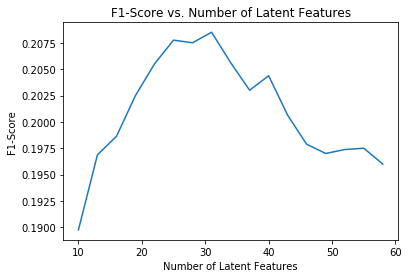

In [252]:
score_func = recall_score
latent_features_sweep_nums = np.arange(10,60,3)
scores = latent_feature_sweep(test_subset, s, u, vt, latent_features_sweep_nums, score_func)

plt.plot(latent_features_sweep_nums, scores);
plt.xlabel('Number of Latent Features');
plt.ylabel('F1-Score');
plt.title('F1-Score vs. Number of Latent Features');

